In [1]:
import pandas as pd
import numpy as np

import warnings
# Code was showing some warnings, from stack overflow optimal answer was to include this
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df= pd.read_csv("fetal_health.csv")

In [3]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
X = df.iloc[:, :-1]  
y = df.iloc[:, -1]   


## Splitting & Using XGB


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train_encoded)

y_pred_encoded = xgb_classifier.predict(X_test)

y_pred = le.inverse_transform(y_pred_encoded)



## Using Evaluation Metrics

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Calculating using average micro
print("Accuracy = ", accuracy_score(y_test, y_pred) * 100, "%")
print("Precision = ", precision_score(y_test, y_pred,average='micro'))
print("Recall = ", recall_score(y_test, y_pred,average='micro'))
print("F1-score = ", f1_score(y_test, y_pred,average='micro'))
print("Confusion Matrix = ")
print(confusion_matrix(y_test, y_pred))
print ("********")
# Using classification report too
print("Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Accuracy =  96.0093896713615 %
Precision =  0.960093896713615
Recall =  0.960093896713615
F1-score =  0.960093896713615
Confusion Matrix = 
[[325   7   1]
 [  8  55   1]
 [  0   0  29]]
********
Classification Report
              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98       333
         2.0       0.89      0.86      0.87        64
         3.0       0.94      1.00      0.97        29

    accuracy                           0.96       426
   macro avg       0.93      0.95      0.94       426
weighted avg       0.96      0.96      0.96       426



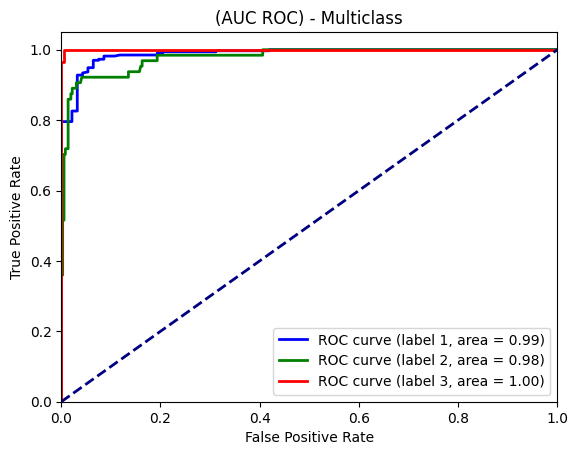

In [8]:
# For multiclass

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_scores = xgb_classifier.predict_proba(X_test)

plt.figure()

n_classes = 3
colors = ['b', 'g', 'r']

for i in range(1, n_classes + 1):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i - 1], y_scores[:, i - 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i - 1], lw=2, label=f'ROC curve (label {i}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(AUC ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()


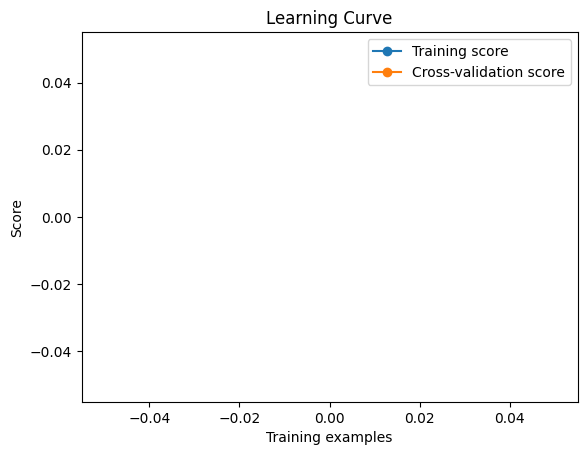

In [9]:
train_sizes, train_scores, test_scores = learning_curve(xgb_classifier, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

In [10]:
# data set had negative value, using log transform to make positive and Adding 1 in X, to prevent log value as infinite

X_log_transformed = np.log1p(X + 1)

kbest = SelectKBest(score_func=chi2, k=5)
X_new = kbest.fit_transform(X_log_transformed, y)


In [11]:
feature_scores = kbest.scores_
print("Feature Importance Scores:")
print(feature_scores)

Feature Importance Scores:
[2.61919200e-01 1.77368755e-03 1.52940324e-02 5.36050691e-04
 3.95730127e-04 6.56463269e-08 8.59609816e-05 1.68957195e+01
 1.45339333e+01 5.29494011e+02 4.23579355e+01 1.72531418e+01
 3.22287127e+00 1.27957858e-02 5.13797999e+00 5.46795895e-01
 1.72059243e+00 1.58334943e+00 1.05026330e+00 1.21194002e+02
 1.18517227e+01]


## Checking class distribution

Class Distribution:
fetal_health
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64
Coefficient of Variation (CV): 1.1595095195631708


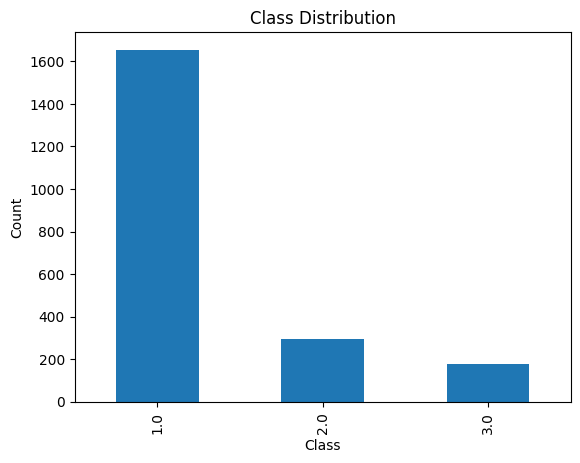

In [12]:

target_column = 'fetal_health'

class_distribution = df[target_column].value_counts()

mean_class_size = class_distribution.mean()
std_class_size = class_distribution.std()
imbalance_cv = std_class_size / mean_class_size

print(f"Class Distribution:\n{class_distribution}")
print(f"Coefficient of Variation (CV): {imbalance_cv}")

class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## Applying SMOTE


In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)




Class Distribution:
fetal_health
1.0    1322
2.0    1322
3.0    1322
Name: count, dtype: int64
Coefficient of Variation (CV): 0.0


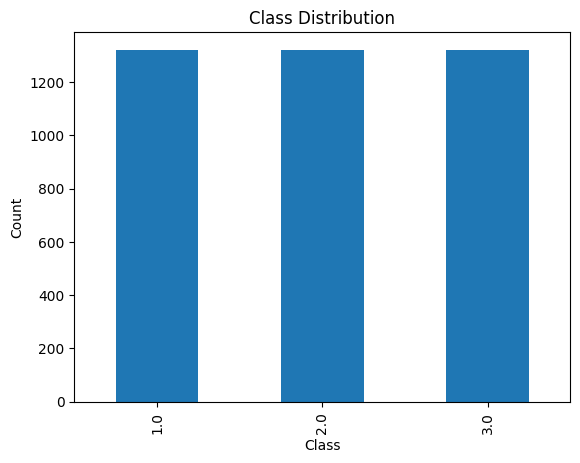

In [14]:


class_distribution = y_resampled.value_counts()

mean_class_size = class_distribution.mean()
std_class_size = class_distribution.std()
imbalance_cv = std_class_size / mean_class_size

print(f"Class Distribution:\n{class_distribution}")
print(f"Coefficient of Variation (CV): {imbalance_cv}")

class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## Using XGB

In [15]:
le = LabelEncoder()
y_resampled_encoded = le.fit_transform(y_resampled)

xgb_classifier_after = xgb.XGBClassifier()
xgb_classifier_after.fit(X_resampled, y_resampled_encoded)

y_pred_encoded = xgb_classifier_after.predict(X_test)

y_pred_after = le.inverse_transform(y_pred_encoded)


## Using Evaluation Metrics

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Calculating using average micro
print("Accuracy = ", accuracy_score(y_test, y_pred_after) * 100, "%")
print("Precision = ", precision_score(y_test, y_pred_after,average='micro'))
print("Recall = ", recall_score(y_test, y_pred_after,average='micro'))
print("F1-score = ", f1_score(y_test, y_pred_after,average='micro'))
print("Confusion Matrix = ")
print(confusion_matrix(y_test, y_pred_after))
print ("********")
# Using classification report too
print("Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_after))


Accuracy =  96.0093896713615 %
Precision =  0.960093896713615
Recall =  0.960093896713615
F1-score =  0.960093896713615
Confusion Matrix = 
[[325   7   1]
 [  7  56   1]
 [  1   0  28]]
********
Classification Report
              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98       333
         2.0       0.89      0.88      0.88        64
         3.0       0.93      0.97      0.95        29

    accuracy                           0.96       426
   macro avg       0.93      0.94      0.94       426
weighted avg       0.96      0.96      0.96       426



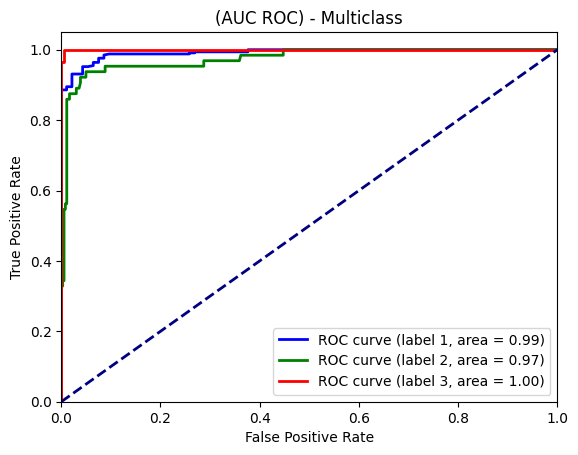

In [17]:
# For multiclass

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_scores = xgb_classifier_after.predict_proba(X_test)


plt.figure()

n_classes = 3
colors = ['b', 'g', 'r']

for i in range(1, n_classes + 1):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i - 1], y_scores[:, i - 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i - 1], lw=2, label=f'ROC curve (label {i}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(AUC ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()


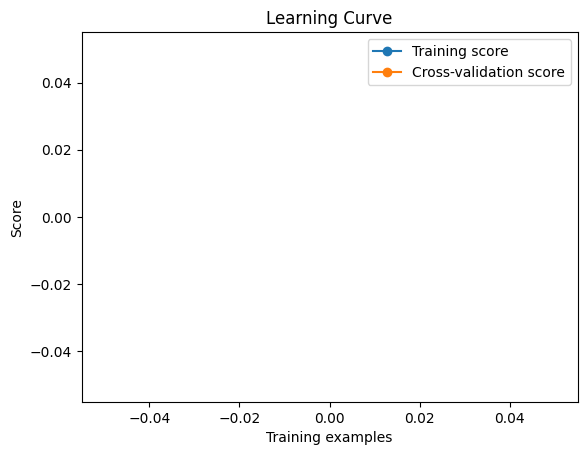

In [18]:
train_sizes, train_scores, test_scores = learning_curve(xgb_classifier_after, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

In [19]:
# data set had negative value, using log transform to make positive and Adding 1 in X, to prevent log value as infinite

X_log_transformed = np.log1p(X + 1)

kbest = SelectKBest(score_func=chi2, k=5)
X_new = kbest.fit_transform(X_log_transformed, y)

feature_scores = kbest.scores_
print("Feature Importance Scores:")
print(feature_scores)

Feature Importance Scores:
[2.61919200e-01 1.77368755e-03 1.52940324e-02 5.36050691e-04
 3.95730127e-04 6.56463269e-08 8.59609816e-05 1.68957195e+01
 1.45339333e+01 5.29494011e+02 4.23579355e+01 1.72531418e+01
 3.22287127e+00 1.27957858e-02 5.13797999e+00 5.46795895e-01
 1.72059243e+00 1.58334943e+00 1.05026330e+00 1.21194002e+02
 1.18517227e+01]
